# Approximate sin function

The model of sin is generated using numpy/keras on Python.

```python
import numpy as np
x = np.linspace(-3.3, 3.4, 40)
y = np.sin(x)
data = np.c_[x, y]
np.savetxt('out.csv', data, delimiter=',', header='x,y', newline='\n')
```

```python
import numpy as np 
from tensorflow.contrib.keras.api.keras.models import Sequential, model_from_json
from tensorflow.contrib.keras.api.keras.layers import Dense, Dropout, Activation
from tensorflow.contrib.keras.api.keras.optimizers import SGD, Adam
import tensorflow.contrib.lite as lite

data = np.loadtxt('sin.csv', delimiter = ',', unpack = True)
model = Sequential()
model.add(Dense(30, input_shape = (1, )))
model.add(Activation('sigmoid'))
model.add(Dense(40))
model.add(Activation('sigmoid'))
model.add(Dense(1))
sgd = Adam(lr = 0.1)
model.compile(loss = 'mean_squared_error', optimizer = sgd)
model.fit(data[0], data[1], epochs = 1000, batch_size = 20, verbose = 0)
model.save('sin_model.h5')

converter = lite.TFLiteConverter.from_keras_model_file('sin_model.h5')
tflite_model = converter.convert()
open('sin_model.tflite', 'wb').write(tflite_model)
```

At the first, import packages.

In [1]:
import (
    "fmt"
    "log"
    "math"
)

And go-tflite

In [2]:
import "github.com/mattn/go-tflite"

Load tflite model file that is generated by Python.

In [3]:
model := tflite.NewModelFromFile("sin_model.tflite")
if model == nil {
    log.Fatal("cannot load model")
}

Now you can create interpreter of TensorFlow Lite. The second argument is InterpreterOptions. If you want to specify thread number of the interpreter, modify options that created by NewInterpreterOptions.
```go
options := tflite.NewInterpreterOptions()
options.SetNumThread(4)
defer options.Delete()
interpreter := tflite.NewInterpreter(model, options)
```

In [4]:
interpreter := tflite.NewInterpreter(model, nil)

Allocate tensors according to the model.

In [5]:
if status := interpreter.AllocateTensors(); status != tflite.OK {
    log.Fatal("cannot allocate tensors")
}

Now interpreter have input/output tensors. You can update input tensor.

In [6]:
input := interpreter.GetInputTensor(0)

So the `input` is a slice of values that can make sure the type with `Type()`.

In [7]:
input.Type()

Float32

You can update this slice directly. For example, 0 for sin(0).

In [8]:
input.SetFloat32s([]float32{0})

Then, call `Invoke()`

In [9]:
if status := interpreter.Invoke(); status != tflite.OK {
    log.Fatal("cannot invoke")
}

In [10]:
interpreter.GetOutputTensor(0).Float32s()[0]

-0.021990374

This is approximated sin(0).

In [11]:
for i := -180; i < 180; i+=10 {
    v := float32(i) * math.Pi / 180.0
    interpreter.GetInputTensor(0).SetFloat32s([]float32{v})
    interpreter.Invoke()
    got := float64(interpreter.GetOutputTensor(0).Float32s()[0])
    fmt.Printf("approximate sin(%f) = %f, real sin(%f) = %f\n", v, got, v, math.Sin(float64(v)))
}

approximate sin(-3.141593) = -0.056293, real sin(-3.141593) = 0.000000
approximate sin(-2.967060) = -0.226687, real sin(-2.967060) = -0.173648
approximate sin(-2.792527) = -0.399581, real sin(-2.792527) = -0.342020
approximate sin(-2.617994) = -0.559051, real sin(-2.617994) = -0.500000
approximate sin(-2.443461) = -0.695790, real sin(-2.443461) = -0.642787
approximate sin(-2.268928) = -0.807819, real sin(-2.268928) = -0.766044
approximate sin(-2.094395) = -0.896549, real sin(-2.094395) = -0.866025
approximate sin(-1.919862) = -0.963138, real sin(-1.919862) = -0.939693
approximate sin(-1.745329) = -1.006974, real sin(-1.745329) = -0.984808
approximate sin(-1.570796) = -1.025686, real sin(-1.570796) = -1.000000
approximate sin(-1.396263) = -1.015978, real sin(-1.396263) = -0.984808
approximate sin(-1.221731) = -0.975021, real sin(-1.221731) = -0.939693
approximate sin(-1.047198) = -0.902026, real sin(-1.047198) = -0.866025
approximate sin(-0.872665) = -0.799135, real sin(-0.872665) = -0.

Plot approximate sin(X)

In [12]:
import (
    "bytes"
    "bufio"
    
    "image/color"
    "gonum.org/v1/gonum/mat"
    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/vg"
)

In [13]:
p, err := plot.New()
if err != nil {
    panic(err)
}
p.Title.Text = "Approximate sin function"
p.X.Label.Text = "X"
p.Y.Label.Text = "Sin(X)"

approximate := plotter.NewFunction(func(x float64) float64 {
    interpreter.GetInputTensor(0).SetFloat32s([]float32{float32(x)})
    interpreter.Invoke()
    return float64(interpreter.GetOutputTensor(0).Float32s()[0])
})
approximate.Color = color.RGBA{B: 255, A: 255}

sin := plotter.NewFunction(func(x float64) float64 {
    return math.Sin(x)
})
sin.Dashes = []vg.Length{vg.Points(2), vg.Points(2)}
sin.Color = color.RGBA{R: 255, A: 255}

p.Add(approximate, sin)
p.Legend.Add("approximate sin(x)", approximate)
p.Legend.Add("real sin(x)", sin)
p.Legend.ThumbnailWidth = vg.Inch

p.X.Min = -math.Pi
p.X.Max = math.Pi
p.Y.Min = -1
p.Y.Max = 1

w, err := p.WriterTo(8*vg.Inch, 3.5*vg.Inch, "png")
if err != nil{
    panic(err)
}
var b bytes.Buffer
writer := bufio.NewWriter(&b)
w.WriteTo(writer)

24802 <nil>

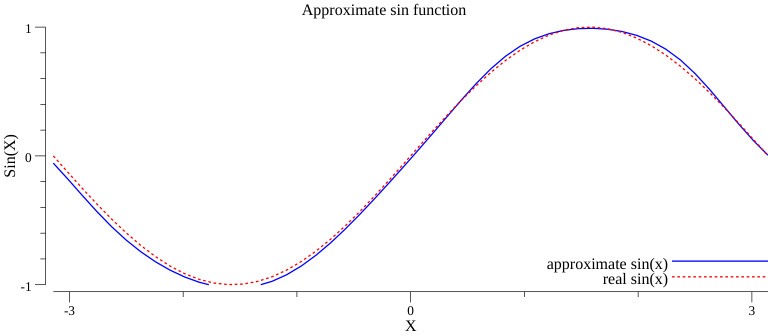

In [14]:
display.PNG(b.Bytes())